In [3]:
import librosa
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression

**When to use**: When the output variables are categorical (such as short, medium, long). It is a simple and efficient technique for binary or multi-class classification.

**Advantage**: Fast, easy to implement and interpret.

**Applicable**: Since our problem has three classes, we can use a multinomial logistic regression.

In [2]:
# Path to the dataset
audio_folder = '../dataset_normalized'

# Function to extract audio features
def extract_features(file_path):
    y, sr = librosa.load(file_path)

    # 1. Duration
    duration = librosa.get_duration(y=y, sr=sr)

    # 2. Amplitude (maximum amplitude)
    amplitude_max = np.max(np.abs(y))

    # 3. FFT (Frequency Analysis)
    fft = np.fft.fft(y)
    magnitude = np.abs(fft)
    frequency = np.fft.fftfreq(len(magnitude), 1/sr)
    dominant_frequency = frequency[np.argmax(magnitude)]

    # 4. Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

    # 5. Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()

    # Return all features as a list
    return [duration, amplitude_max, dominant_frequency, spectral_centroid, zero_crossing_rate]

# Create lists to store file names and their corresponding features
audio_features = []
labels = []

# Assuming you have a separate CSV file with the labels for each file
labels_df = pd.read_csv('audio_durations_labels.csv')  # Load the labels CSV

# Iterate through all audio files in the dataset folder
for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):  # Make sure to adjust if the files are different
        file_path = os.path.join(audio_folder, filename)
        # Extract features from the audio file
        features = extract_features(file_path)
        # Find the label from the labels_df for this file
        label = labels_df[labels_df['file_name'] == filename]['label'].values[0]
        
        # Append the features and label
        audio_features.append(features)
        labels.append(label)

# Convert the audio features and labels into a DataFrame
features_df = pd.DataFrame(audio_features, columns=['duration', 'amplitude_max', 'dominant_frequency', 'spectral_centroid', 'zero_crossing_rate'])
features_df['label'] = labels

# Prepare the features (X) and labels (y)
X = features_df[['amplitude_max', 'dominant_frequency', 'spectral_centroid', 'zero_crossing_rate']]  # You can include/exclude any feature
y = features_df['label']

# Encode the labels (short, medium, long) into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.8864864864864865

Classification Report:
               precision    recall  f1-score   support

        long       0.92      0.96      0.94        70
      medium       0.78      0.69      0.73        42
       short       0.91      0.93      0.92        73

    accuracy                           0.89       185
   macro avg       0.87      0.86      0.86       185
weighted avg       0.88      0.89      0.88       185



# Random Forest Classifier
**When to use**: When you have multiple features and want to capture complex interactions between them. Random Forest is an ensemble of decision trees and generally provides good results for classification.

**Advantage**: Handles complex data well and is less susceptible to overfitting than a single decision tree.

In [5]:
# Load the combined dataset (features + labels)
combined_df = pd.read_csv('combined_audio_data.csv')

# Display the first few rows
combined_df.head()


,duration,amplitude_max,dominant_frequency,spectral_centroid,zero_crossing_rate,file_name,duration_seconds,label
0,3.400000,0.110510,54.705882,2693.875832,0.120811,IMG_6969.wav,3.400000,short
1,13.030023,0.131408,101.841726,2400.584924,0.112325,IMG_6955.wav,13.030023,long
2,8.780000,0.107243,102.733485,2363.703953,0.105469,IMG_6941.wav,8.780000,medium
3,18.310023,0.596768,49.371867,2378.741314,0.084683,IMG_6772.wav,18.310023,long
4,13.530023,0.336703,131.115819,2262.181480,0.114526,IMG_9327.wav,13.530023,long


## Prepare the Data
We will use the features (e.g., amplitude_max, spectral_centroid, etc.) as the input (X), and the label (short, medium, long) as the target (y).

In [6]:
# Prepare the features (X) and the target (y)
X = combined_df[['amplitude_max', 'spectral_centroid', 'dominant_frequency', 'zero_crossing_rate']]
y = combined_df['label']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Train the Random Forest Classifier
Now, we will train the Random Forest Classifier and fit it to the training data.

In [7]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)


## Evaluate the Model
After training the model, we will evaluate its performance using accuracy, confusion matrix, and classification report.

Accuracy: 0.5243

Classification Report:
               precision    recall  f1-score   support

        long       0.56      0.71      0.63        70
      medium       0.33      0.21      0.26        42
       short       0.55      0.52      0.54        73

    accuracy                           0.52       185
   macro avg       0.48      0.48      0.48       185
weighted avg       0.51      0.52      0.51       185



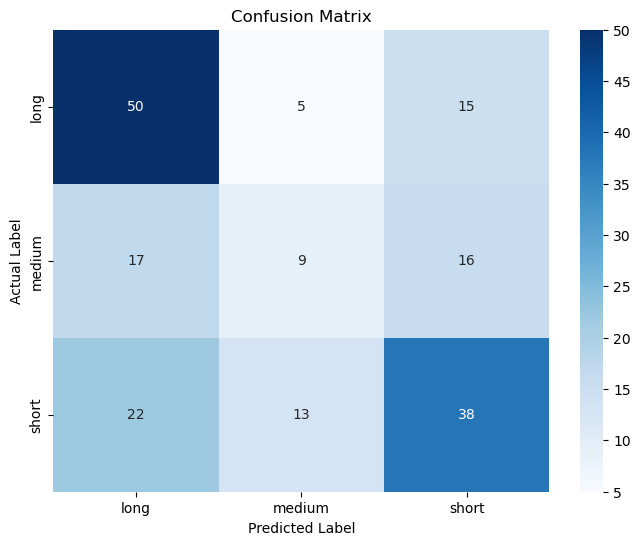

In [8]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
